In [189]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error

import pandas_profiling

In [190]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip',  parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
sample_submissions = pd.read_csv('sample_submission.csv.zip')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv.zip')

In [191]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [192]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [193]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.0,1
1,2013-03-01,0,25,2552,899.0,1
2,2013-05-01,0,25,2552,899.0,-1


In [194]:
sample_submissions.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [195]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [196]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


## Here we merge all tables related with the train data into one table

In [197]:
# merge data into one table
train = sales_train.join(items, on = 'item_id', rsuffix='_')\
                    .join(item_categories, on = 'item_category_id', rsuffix = '_')\
                    .join(shops, on = 'shop_id', rsuffix = '_')\
                    .drop(['item_id_', 'shop_id_', 'item_category_id_', 'item_name'], axis=1)

train['item_cnt_day'] = np.abs(train['item_cnt_day'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.000000,1,56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [11]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split dates for more detailed exploration

In [198]:
train['date'] = pd.to_datetime(train['date'], format='%m.%Y')
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

train.head(4)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,3,2013
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,6,2013


## Check our data for missed values

In [199]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
shop_name             0
day                   0
month                 0
year                  0
dtype: int64

## Group data by date, shop, item and category 

In [200]:
# group data by month
train_grouped_by_month = train[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id", "year"]].groupby(['date_block_num',"shop_id", "item_id", "item_category_id"]).agg({"item_price":"mean","item_cnt_day":"sum","month":"min", "year":"min"}).reset_index()
train_grouped_by_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

train_grouped_by_month.head(8)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,month,year
0,0,0,32,40,221.0,6,1,2013
1,0,0,33,37,347.0,3,1,2013
2,0,0,35,40,247.0,1,1,2013
3,0,0,43,40,221.0,1,1,2013
4,0,0,51,57,128.5,2,1,2013
5,0,0,61,43,195.0,1,10,2013
6,0,0,75,40,76.0,1,1,2013
7,0,0,88,40,76.0,1,1,2013


## Here we can see, that almost all grouped sales are clipped into [0, 250]

<AxesSubplot:>

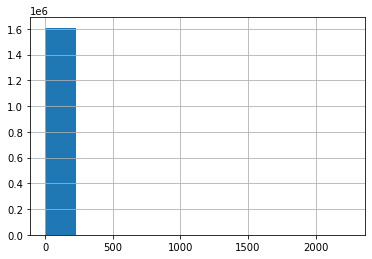

In [201]:
train_grouped_by_month['item_cnt_month'].hist()

## After 20 values are much less than for sales count from [0,20]

In [202]:
train_grouped_by_month.query('item_cnt_month > 20').count()

date_block_num      11497
shop_id             11497
item_id             11497
item_category_id    11497
item_price          11497
item_cnt_month      11497
month               11497
year                11497
dtype: int64

<AxesSubplot:>

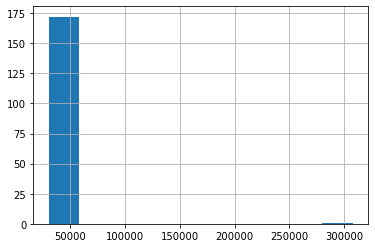

In [203]:
train_grouped_by_month.query('item_price > 30000 and item_price < 350000')['item_price'].hist()

In [204]:
# remove outliers. We delete values less then 21, because final answer values have to belongs to range [0,20]
#train_grouped_by_month = train_grouped_by_month.query('item_cnt_month >= 0 and item_cnt_month <= 20')

In [205]:
# calculate correlation matrix
#sns.heatmap(train_grouped_by_month.drop(['shop_id', 'item_id'], axis=1).corr())

## From this graphic we can obtain that sales have huge values on december

Text(0.5, 1.0, 'Count of sales by date block')

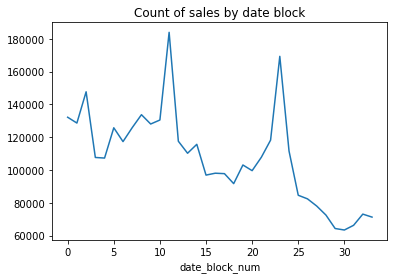

In [206]:
sales_by_date = train_grouped_by_month.groupby(['date_block_num'])['item_cnt_month'].sum()
sales_by_date.plot().set_title('Count of sales by date block')

## Here we delete trend

Text(0.5, 1.0, 'Sequence of differencies')

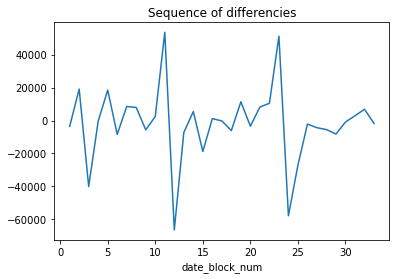

In [207]:
sales_by_date_diff = sales_by_date.diff(periods=1)
sales_by_date_diff.plot().set_title('Sequence of differencies')

## We see that first month has the most biggest sales count

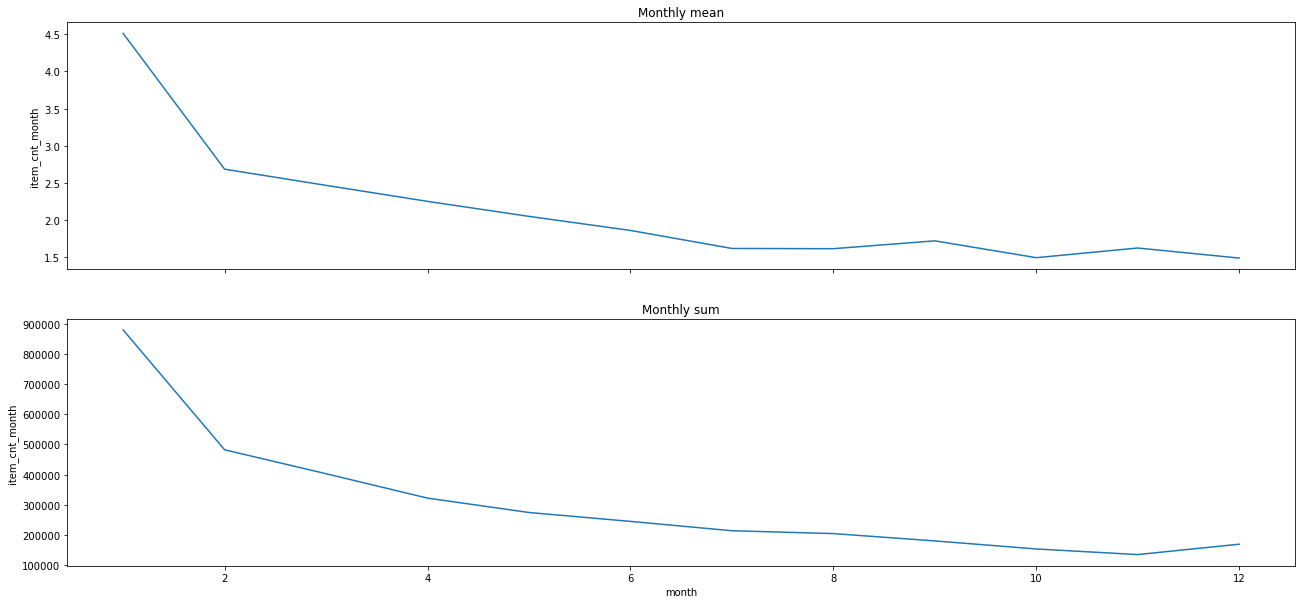

In [208]:
# check for sales statisticks depending on month
month_mean = train_grouped_by_month.groupby(['month'], as_index=False)['item_cnt_month'].mean()
month_sum = train_grouped_by_month.groupby(['month'], as_index=False)['item_cnt_month'].sum()

f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt_month", data=month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt_month", data=month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

## We see that category №40 has more deifferent items, so we can split it into bins in future

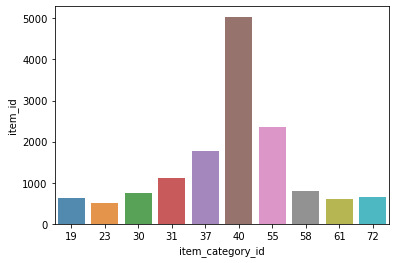

In [209]:
# number of items per category 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.85)
plt.show()

## Obviously sales are decreaing

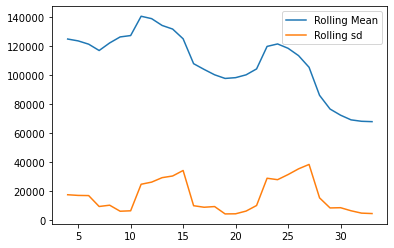

In [210]:
# rolling mean and standart deviation
plt.plot(sales_by_date.rolling(window=5,center=False).mean(),label='Rolling Mean');
plt.plot(sales_by_date.rolling(window=5,center=False).std(),label='Rolling sd');
plt.legend();

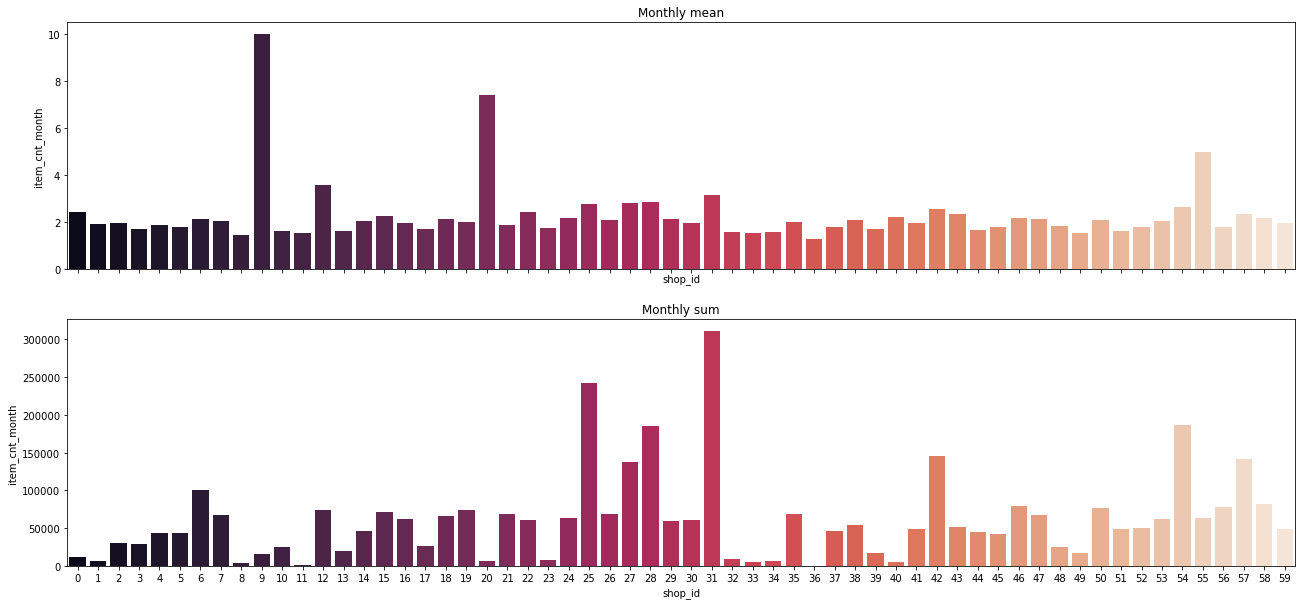

In [211]:
# check for sales statisticks depending on shop
shop_mean = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].mean()
shop_sum = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].sum()

f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## We will use features 'shop_id', 'item_id', 'item_price', 'month', 'year', 'item_cnt_mean', 'shop_item_mean'

In [212]:
gp_shop_mean = train_grouped_by_month.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

gp_item_mean = train_grouped_by_month.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

gp_shop_item_mean = train_grouped_by_month.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

gp_year_mean = train_grouped_by_month.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

gp_month_mean = train_grouped_by_month.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)


train_grouped_by_month = pd.merge(train_grouped_by_month, gp_shop_mean, on=['shop_id'], how='left').drop(['shop_mean'], axis=1)
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_item_mean, on=['item_id'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_year_mean, on=['year'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_month_mean, on=['month'], how='left')

test_upd = pd.merge(test, gp_shop_mean, on=['shop_id'], how='left')
test_upd = pd.merge(test_upd, gp_item_mean, on=['item_id'], how='left')
test_upd = pd.merge(test_upd, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
#test = pd.merge(test, gp_year_mean, on=['year'], how='left')
#test = pd.merge(test, gp_month_mean, on=['month'], how='left')

X_train = train.drop(['item_cnt_day', 'date_block_num'], axis=1)
Y_train = train['item_cnt_day'].astype(int)

train_grouped_by_month.head(3)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,month,year,item_mean,shop_item_mean,year_mean,month_mean
0,0,0,32,40,221.0,6,1,2013,2.670064,8.0,2.281527,4.510583
1,0,0,33,37,347.0,3,1,2013,1.501779,3.0,2.281527,4.510583
2,0,0,35,40,247.0,1,1,2013,2.960000,7.5,2.281527,4.510583


In [213]:
X_train.rename(columns={"shop_mean_x": "shop_mean", "shop_item_mean_x": "shop_item_mean", \
                        "year_mean_x": "year_mean", "month_mean_x": "month_mean", "item_mean_y": "item_mean"}, inplace=True)

test_upd.rename(columns={"shop_mean_y": "shop_mean", "item_mean_y": "item_mean", "shop_item_mean_y": "shop_item_mean", }, inplace=True)

knn_features = ['shop_mean', 'shop_item_mean', 'item_mean']

X_train_sampled = X_train[:40000]
Y_train_sampled = Y_train[:40000]

knn_train = X_train_sampled[knn_features]
knn_test = test_upd[knn_features]
knn_test.fillna(knn_test.mean(), inplace=True)
#knn_test.isna().sum()
knn_test.sample(15)

KeyError: "None of [Index(['shop_mean', 'shop_item_mean', 'item_mean'], dtype='object')] are in the [columns]"

In [214]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_test = knn_scaler.transform(knn_test)

In [215]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [216]:
knn_train_pred = knn_model.predict(knn_train)
knn_test_pred = knn_model.predict(knn_test)

In [217]:
np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred))

0.5374163730523023

In [231]:
final_results = pd.DataFrame(knn_test_pred)
final_results.rename(columns={0:'item_cnt_month'}, inplace=True)
final_results.describe()

,item_cnt_month
count,214200.000000
mean,1.068482
std,0.178133
min,1.000000
25%,1.000000
50%,1.000000
75%,1.111111
max,6.333333


In [236]:
test['item_cnt_month'] = knn_test_pred
#test = test.drop(['item_id', 'shop_id'], axis=1)
test.reset_index(drop=True)

,ID,item_cnt_month
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
...,...,...
214195,214195,1.111111
214196,214196,1.000000
214197,214197,1.000000
214198,214198,1.000000


In [226]:
test.to_csv('result.csv')